In [1]:
# Import the various modules
import uproot;
import pandas as pd;
import numpy as np
import matplotlib.pyplot as plt
import histlite as hl
import math
from scipy.stats import poisson
from pathlib import Path
import pickle as pl
import sys
import glob

from iminuit import cost,Minuit
import glob
import os

import csv

plt.style.use('PictureStyle_v1.mplstyle')

In [107]:
#path information common to all the code
OrPath = '/data/users/berettam/DianaHallC/ThresholdScan_NoiseStudies/'
# # load the run db
# rundata = pd.read_csv('H:/My Drive/2023_CCVRUSA_LSC/Analysis/RunList.csv')
# Runs = rundata[rundata.Include==1].Run.to_numpy()
# RunsDAQ = rundata[rundata.Include==1]['RunCrossDAQ'].to_numpy()
# Runs = [500909]# Runs[np.argsort(RunsDAQ)]
# Runs = [500904,500909, 500911, 500913, 500915, 500918, 500923]
Runs = [500936,500939]#,500942,500943]
# Runs = [500904,500909, 500911, 500913, 500915, 500918, 500923,500936,500939,500941,500942,500943]


making plot directories

In [108]:
for run in Runs:
  if not os.path.isdir(f"/data/users/berettam/DianaHallC/ThresholdScan_NoiseStudies/Plots/Run{run}/"):
    os.mkdir(f"/data/users/berettam/DianaHallC/ThresholdScan_NoiseStudies/Plots/Run{run}/") 
    os.mkdir(f"/data/users/berettam/DianaHallC/ThresholdScan_NoiseStudies/Plots/Run{run}/Integral/") 
    os.mkdir(f"/data/users/berettam/DianaHallC/ThresholdScan_NoiseStudies/Plots/Run{run}/Differential/") 

In [109]:
#channel names/ codes
# detector mapping
DetMap = pd.read_csv('/data/users/berettam/DianaHallC/ChannelMap.csv')

Channels = DetMap.Channel.to_numpy()

AvailChannels = [1,2,4,5,6,11,12,14,15,16,17,18]#[11,12,14,15,16,17,18]#[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]#Channels[2:-2]
AvailLDs = [n for n in AvailChannels if DetMap.Sensor[DetMap.Channel==n].to_numpy()[0]=="Light" ]
AvailHDs = [n for n in AvailChannels if DetMap.Sensor[DetMap.Channel==n].to_numpy()[0]=="Heat" ]


# get current THs from SB

In [110]:
sb = {}
sb[500904] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb261.csv').sort_values('id')
sb[500909] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb261.csv').sort_values('id')
sb[500911] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb261.csv').sort_values('id')
sb[500913] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb261.csv').sort_values('id')
sb[500915] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb261.csv').sort_values('id')
sb[500918] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb261.csv').sort_values('id')
sb[500923] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb263.csv').sort_values('id')
sb[500936] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb266.csv').sort_values('id')
sb[500939] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb269.csv').sort_values('id')
sb[500941] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb269.csv').sort_values('id')
sb[500942] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb269.csv').sort_values('id')
sb[500943] = pd.read_csv('/data/users/berettam/DianaHallC/SettingsBaskets/sb269.csv').sort_values('id')

# Get Scans from TXT

In [117]:
Averages = [5]#[20]#[5]#[4]
Debounce = [5]#[10]#[5]#[4]

In [112]:
AvailHDs

[1, 2, 4, 5, 6]

In [118]:
#list of files
#reading and saving the output into a dataframe
column_names = ["Run", "Channel", "Average", "Debounce", "THs", "Rates"]

AllScans = pd.DataFrame(columns = column_names)

#reading and saving the output into a dataframe
for Avg in Averages:
  for Deb in Debounce:
    for run in Runs:
      for ch in AvailHDs:#[18]: #AvailChannels:
        
        # file to be read    
        f = OrPath+f'/Avg{Avg}/Deb{Deb}/run{run}/ScanTHs_run{run}_CH{ch}.txt'
        
        #read the scan
        my_data = pd.read_csv(f)
        ths = my_data.Threshold.to_numpy()
        rate = my_data.Rate.to_numpy()
        
        #filling the df
        el = [run,ch,Avg,Deb,ths,rate] 
        ss = pd.DataFrame([el],columns = column_names)
        AllScans = pd.concat([AllScans, ss], ignore_index=True)
        # AllScans = AllScans.append(ss)


# Draw the Rate vs Threshold plots
comparing each channel on the different configurations

In [114]:
cmap = plt.colormaps.get_cmap('jet')
markers = np.array([*plt.Line2D.markers.keys()])[2:-4]

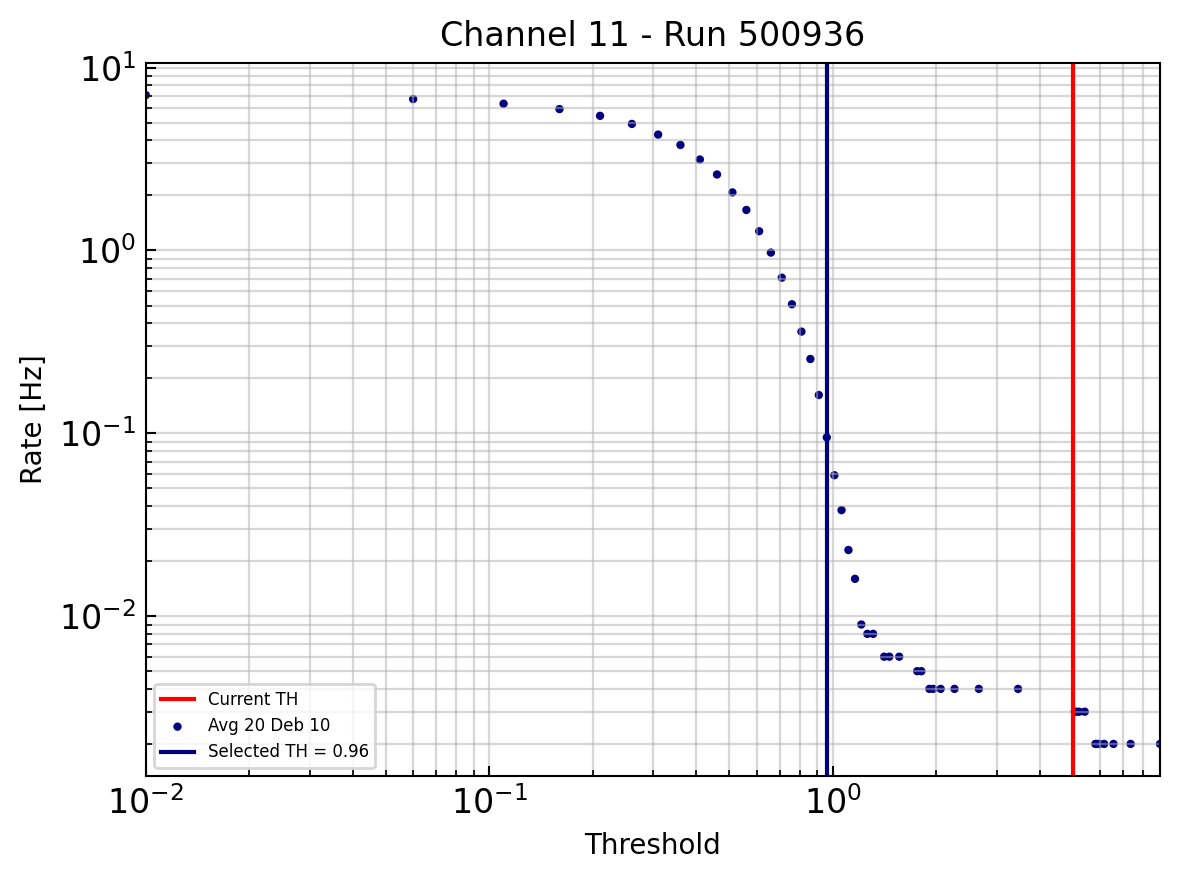

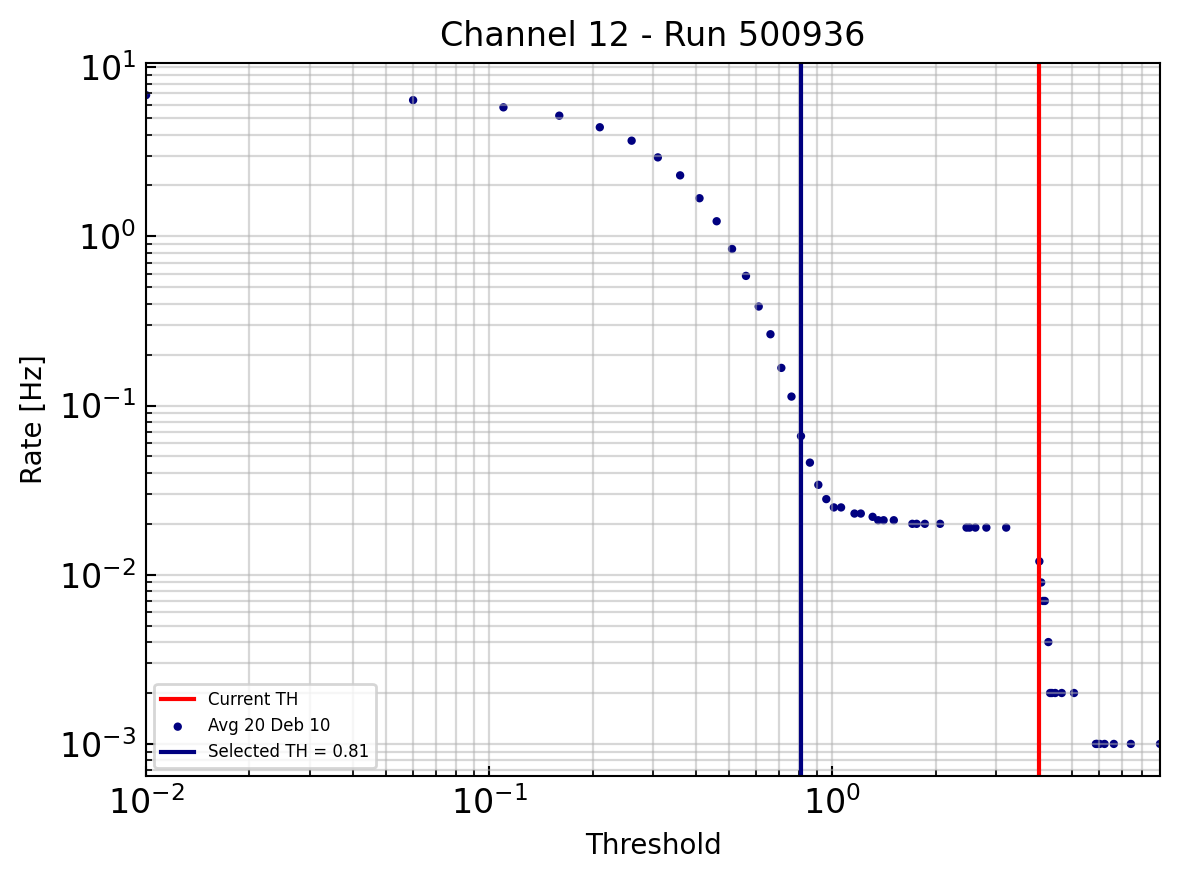

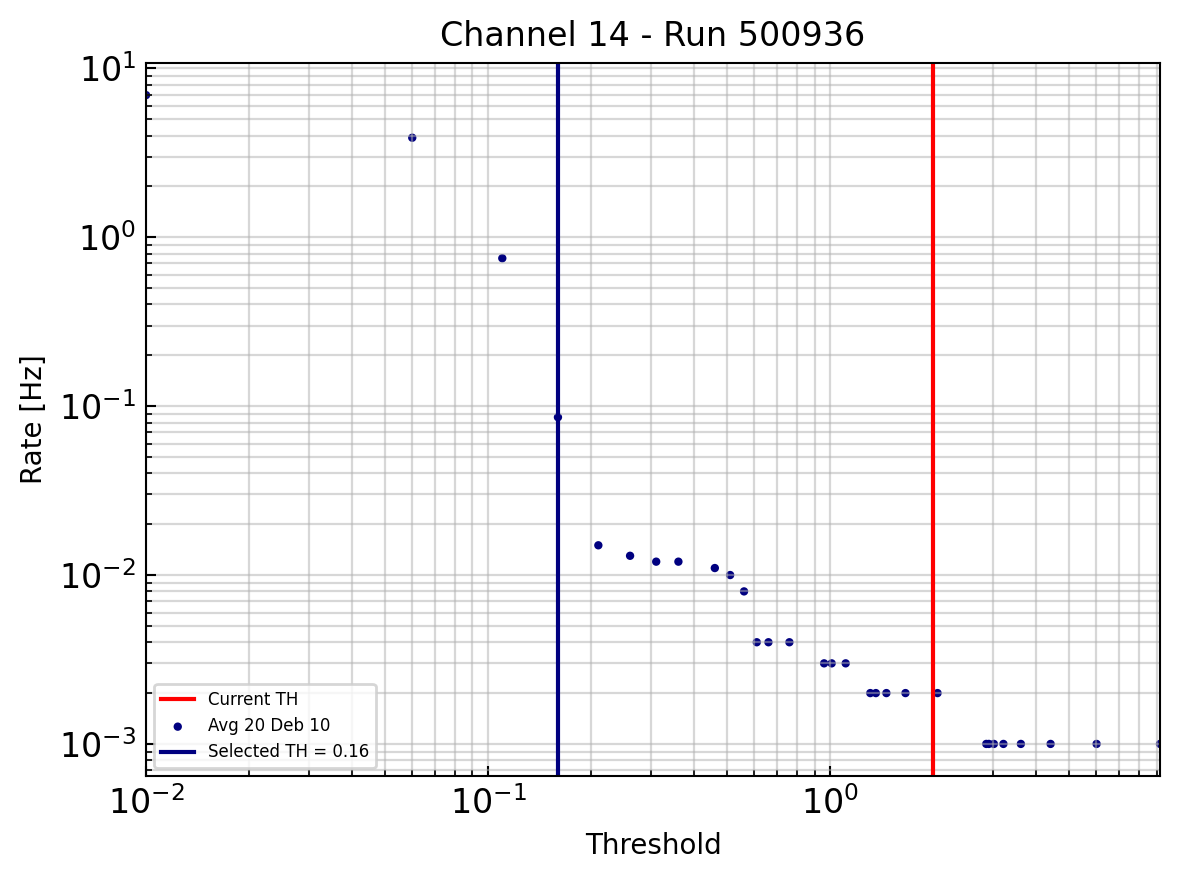

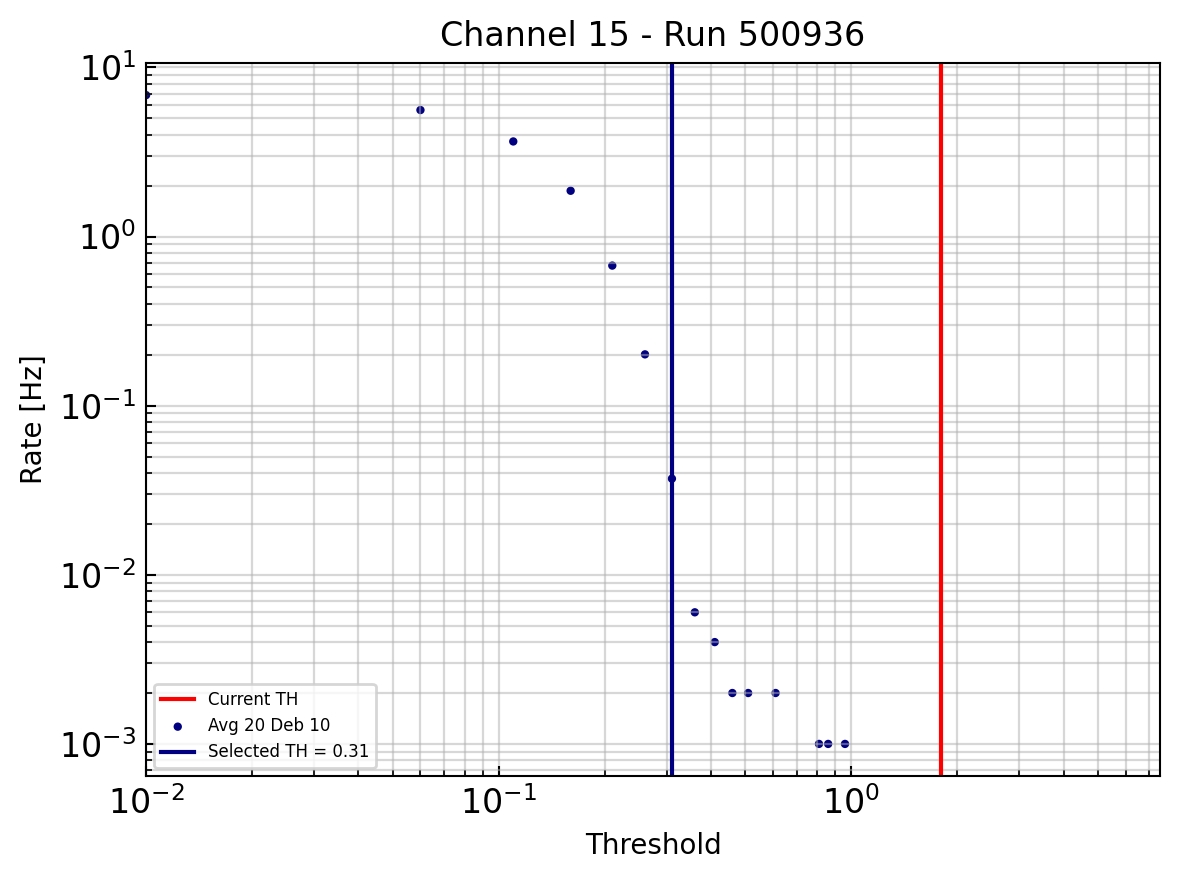

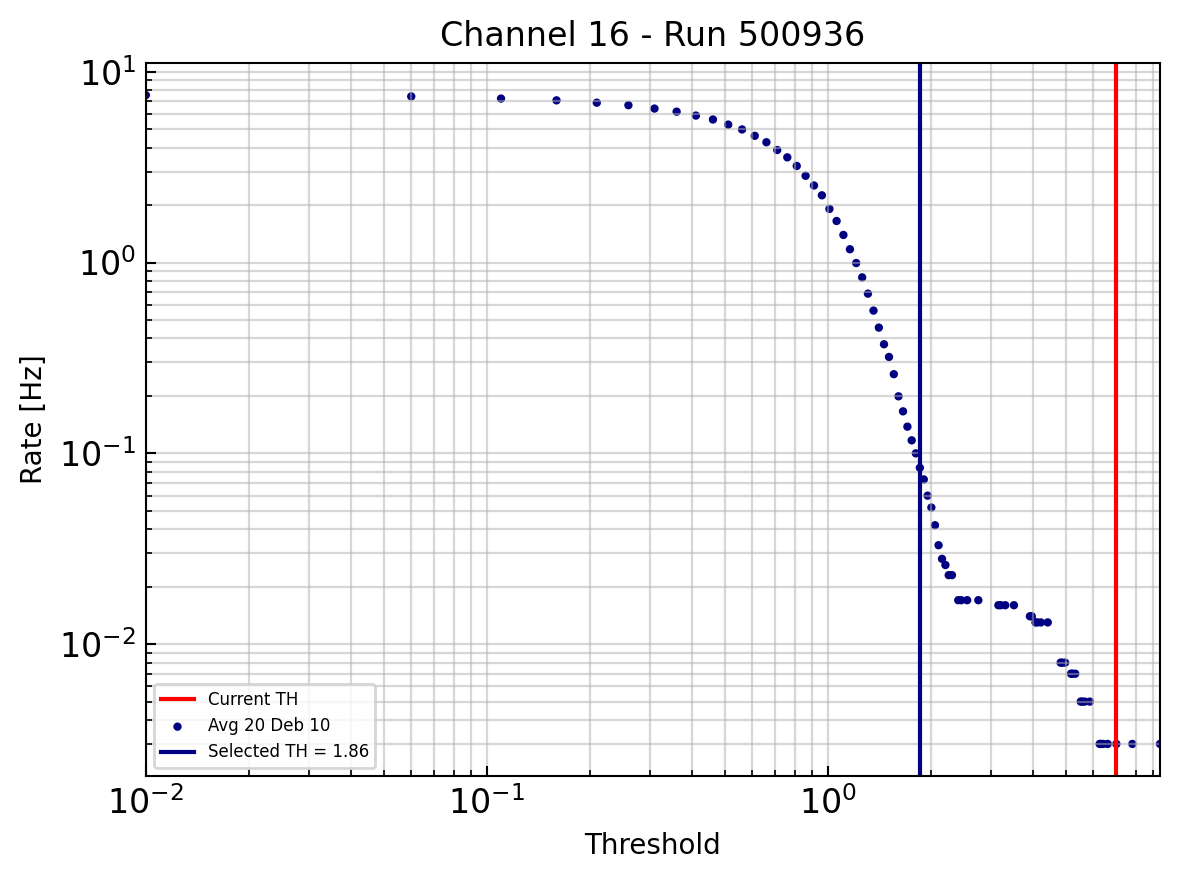

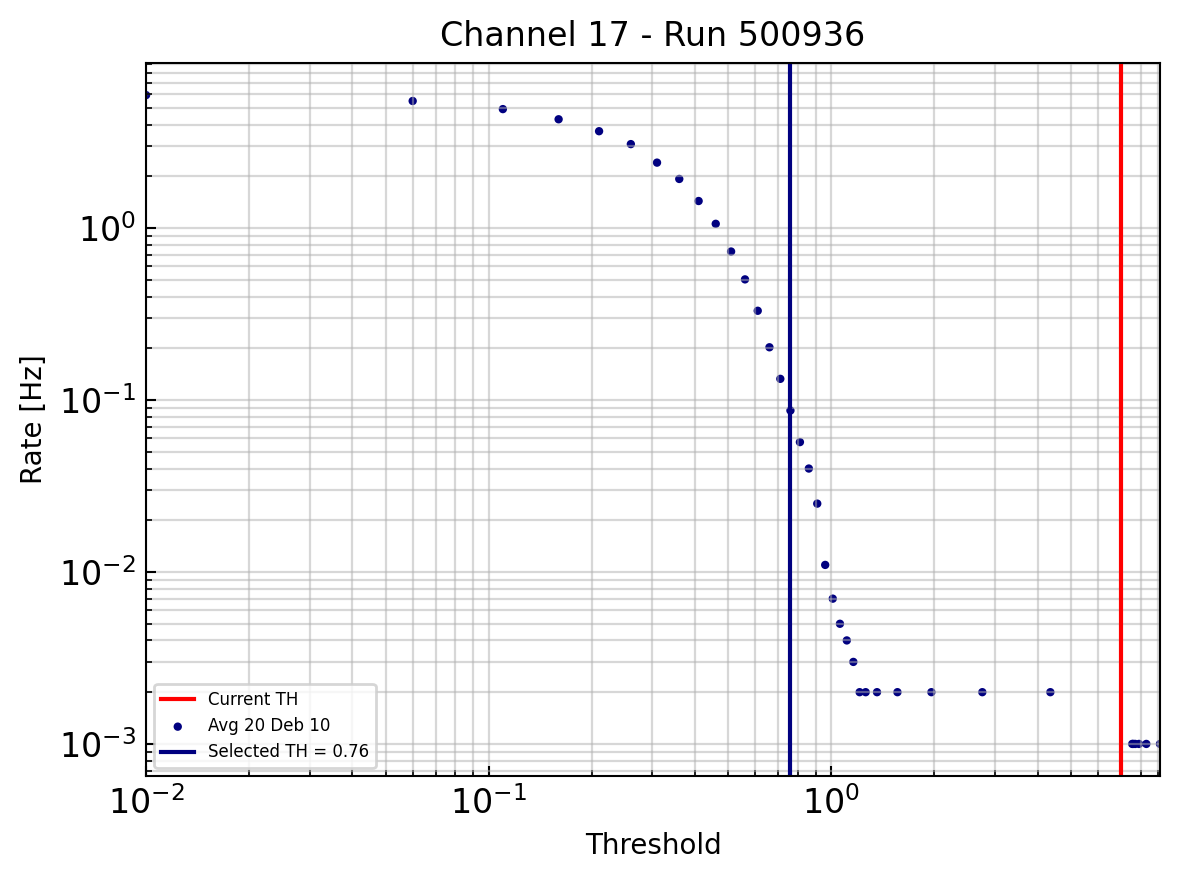

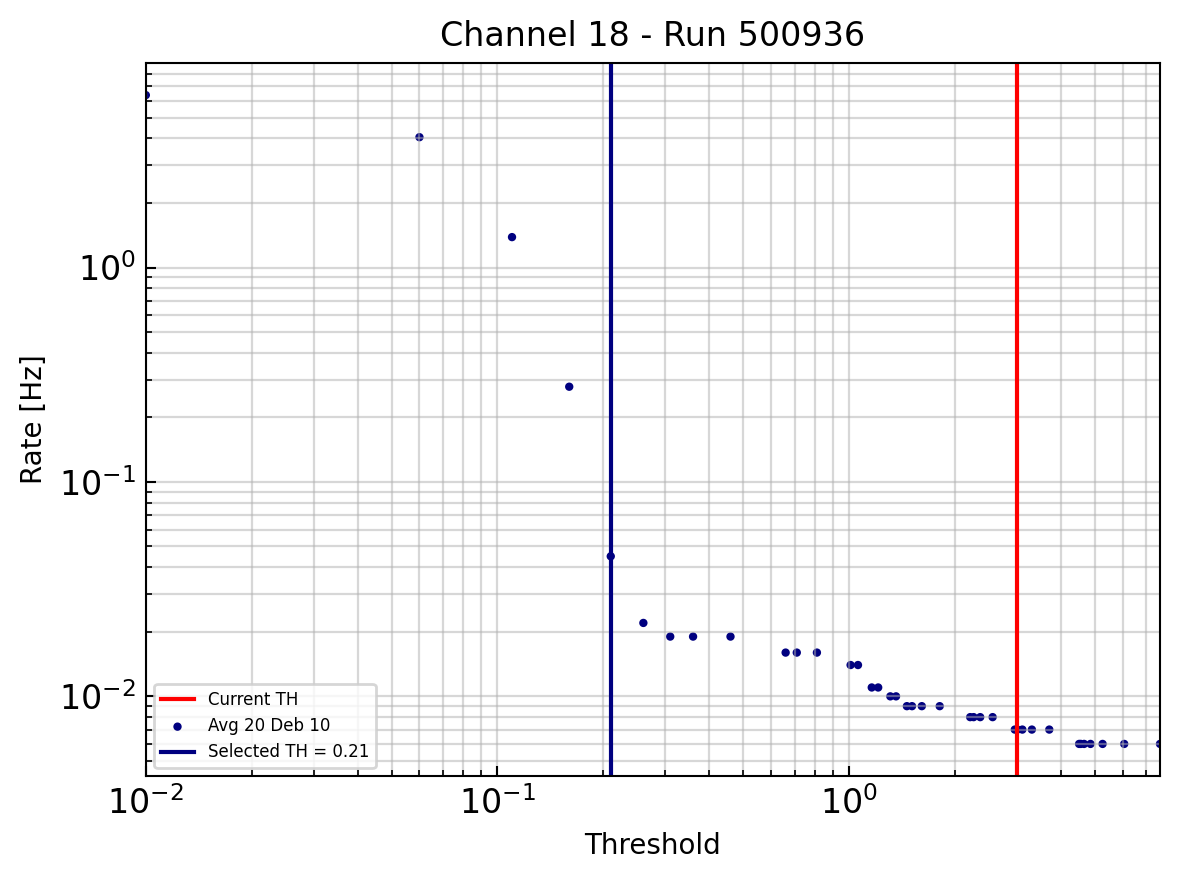

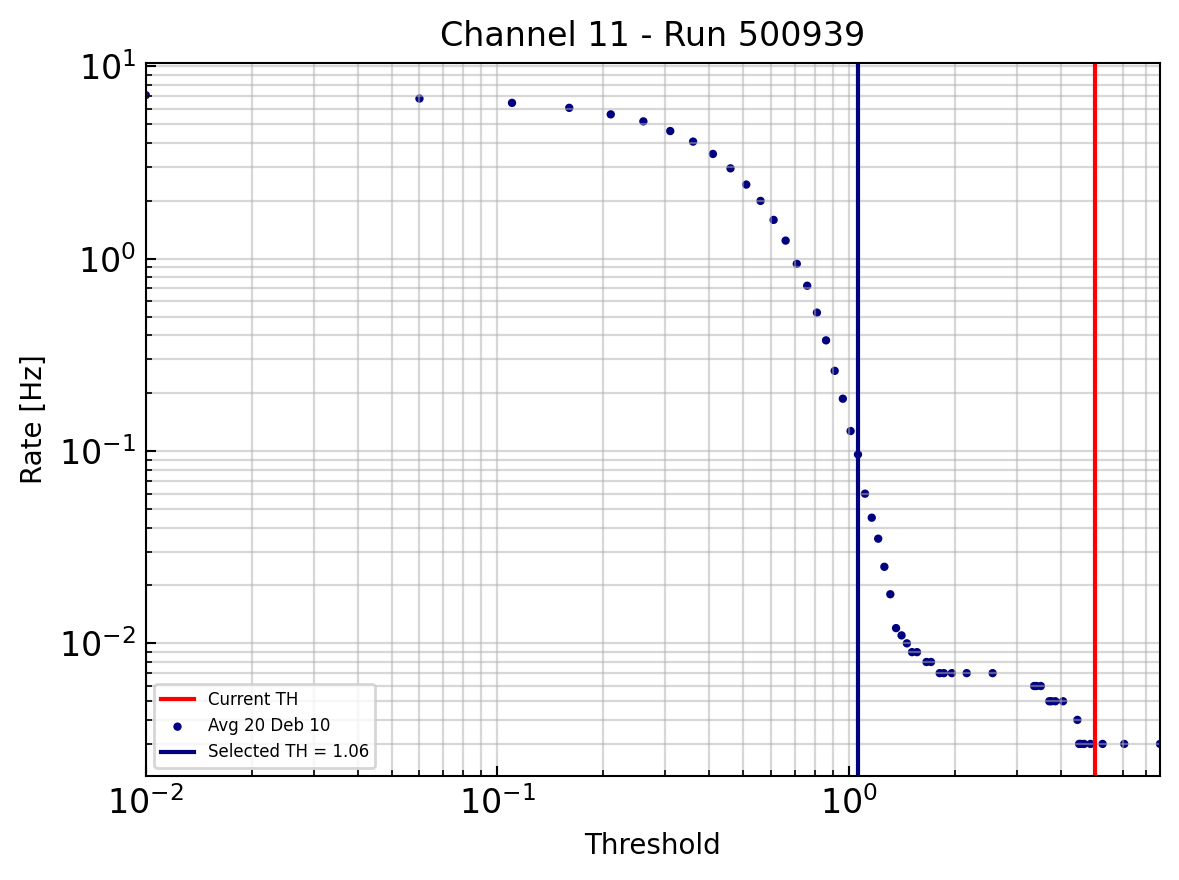

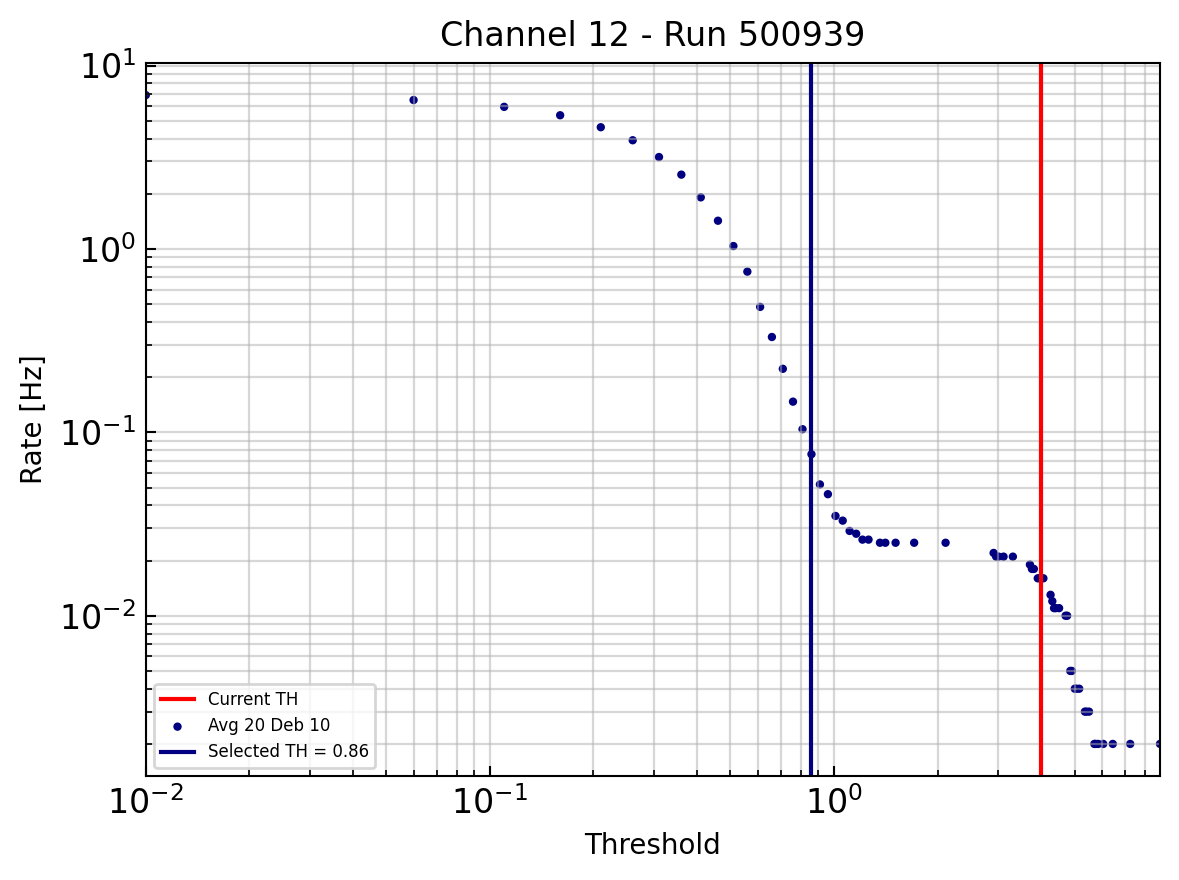

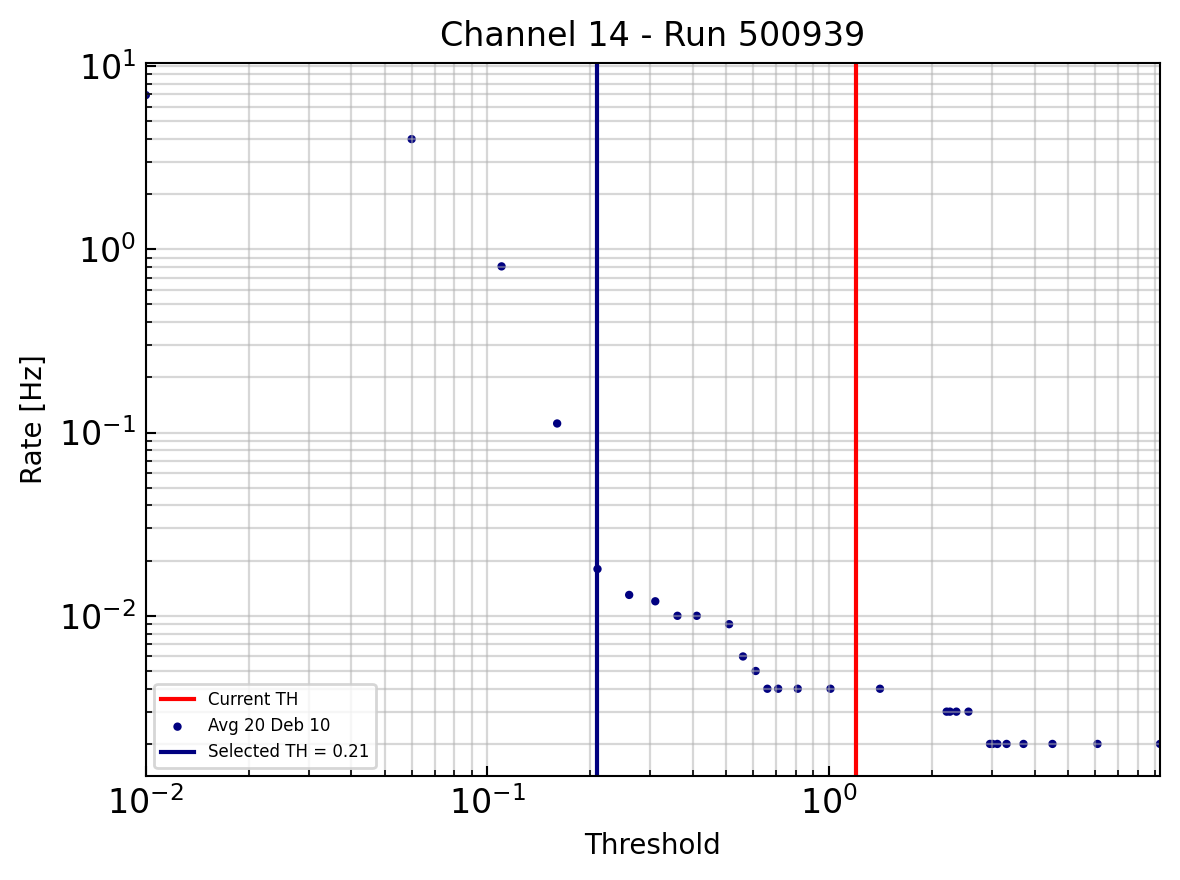

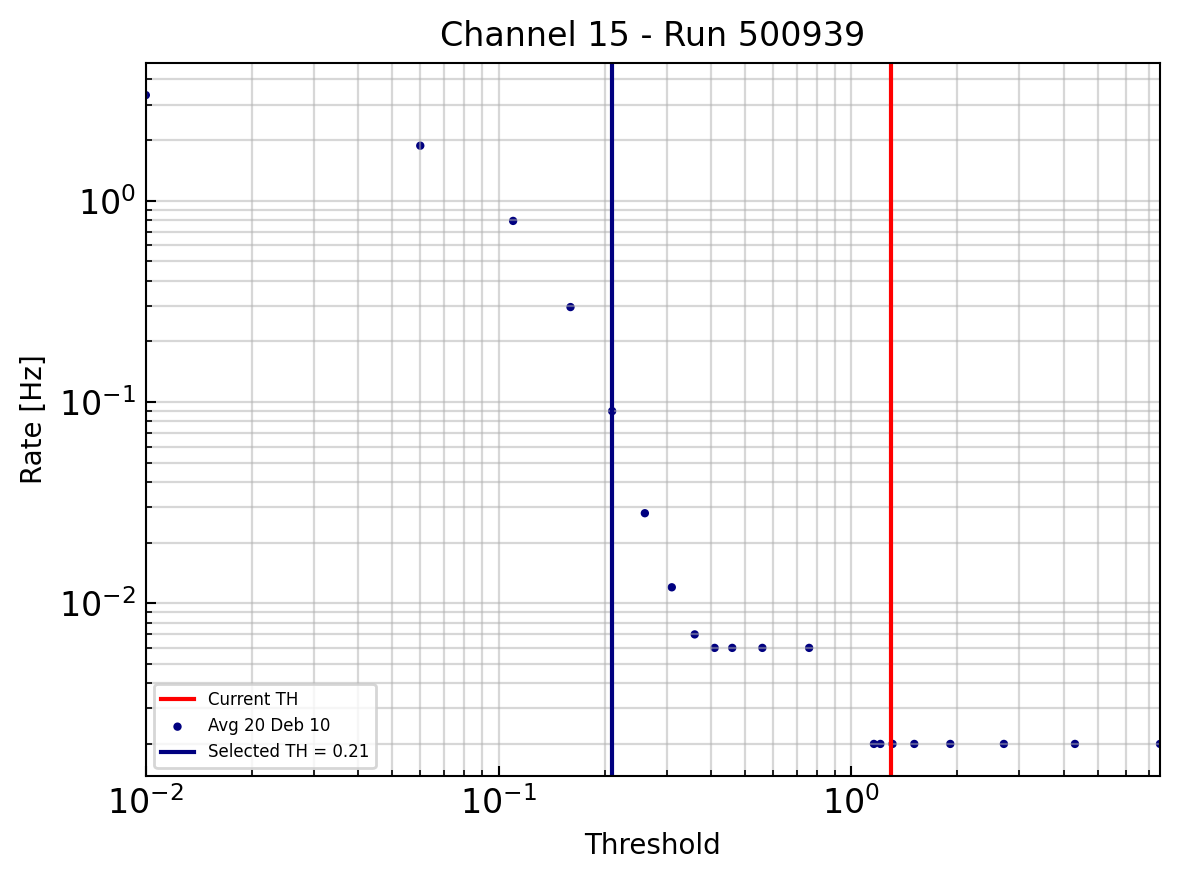

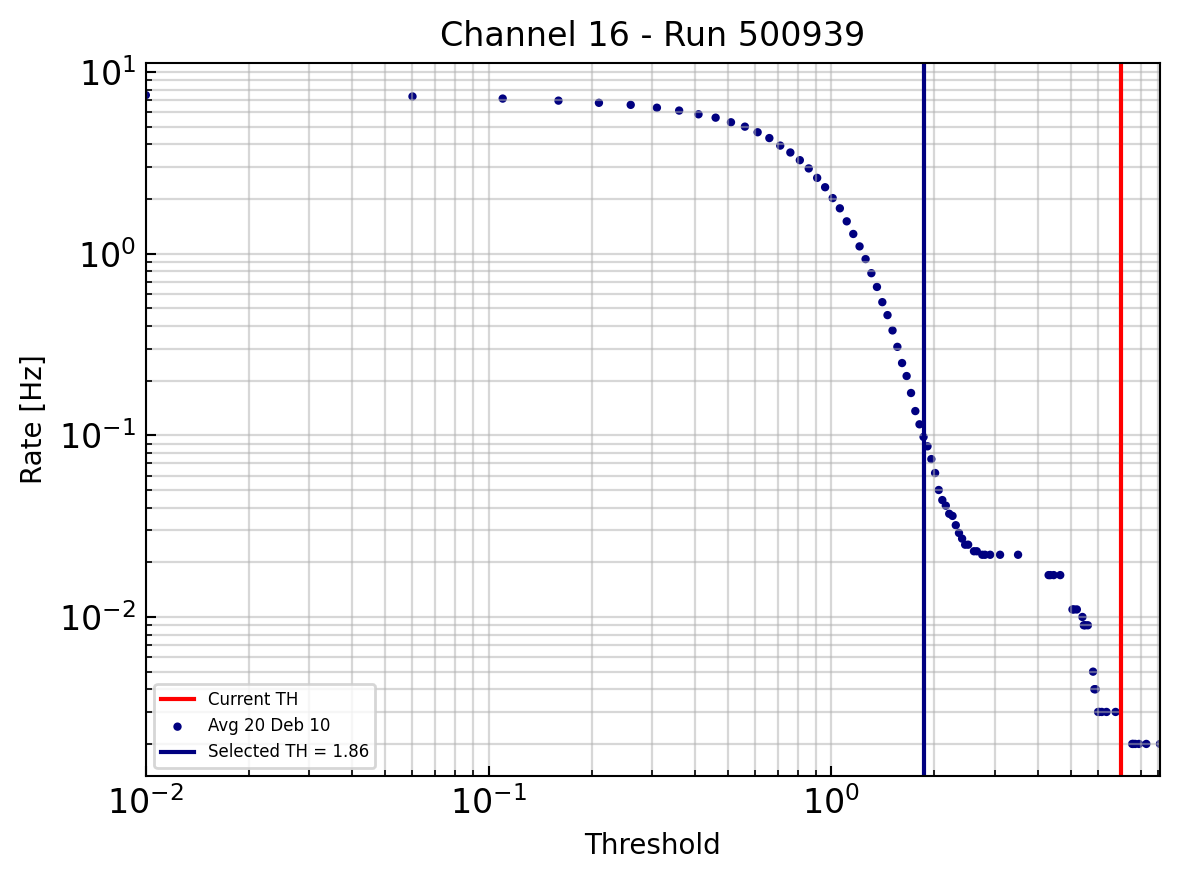

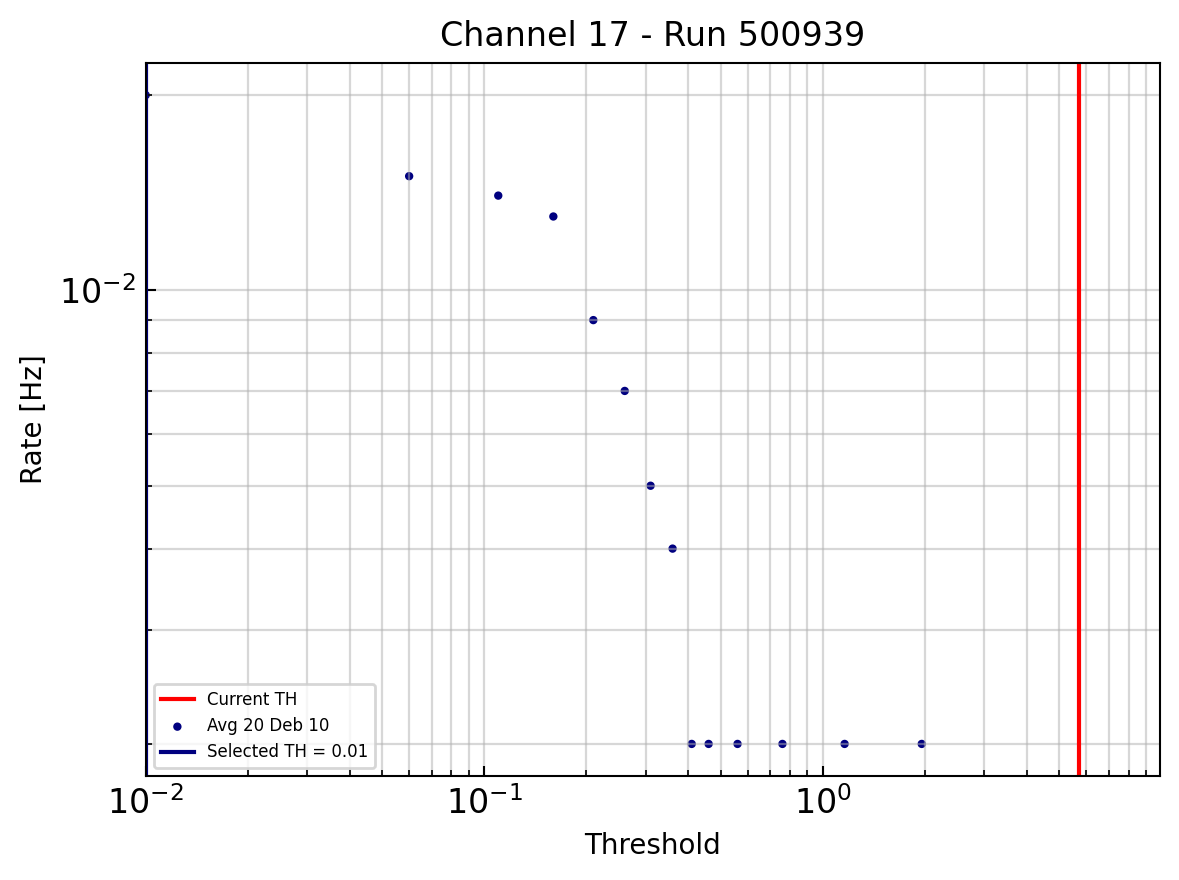

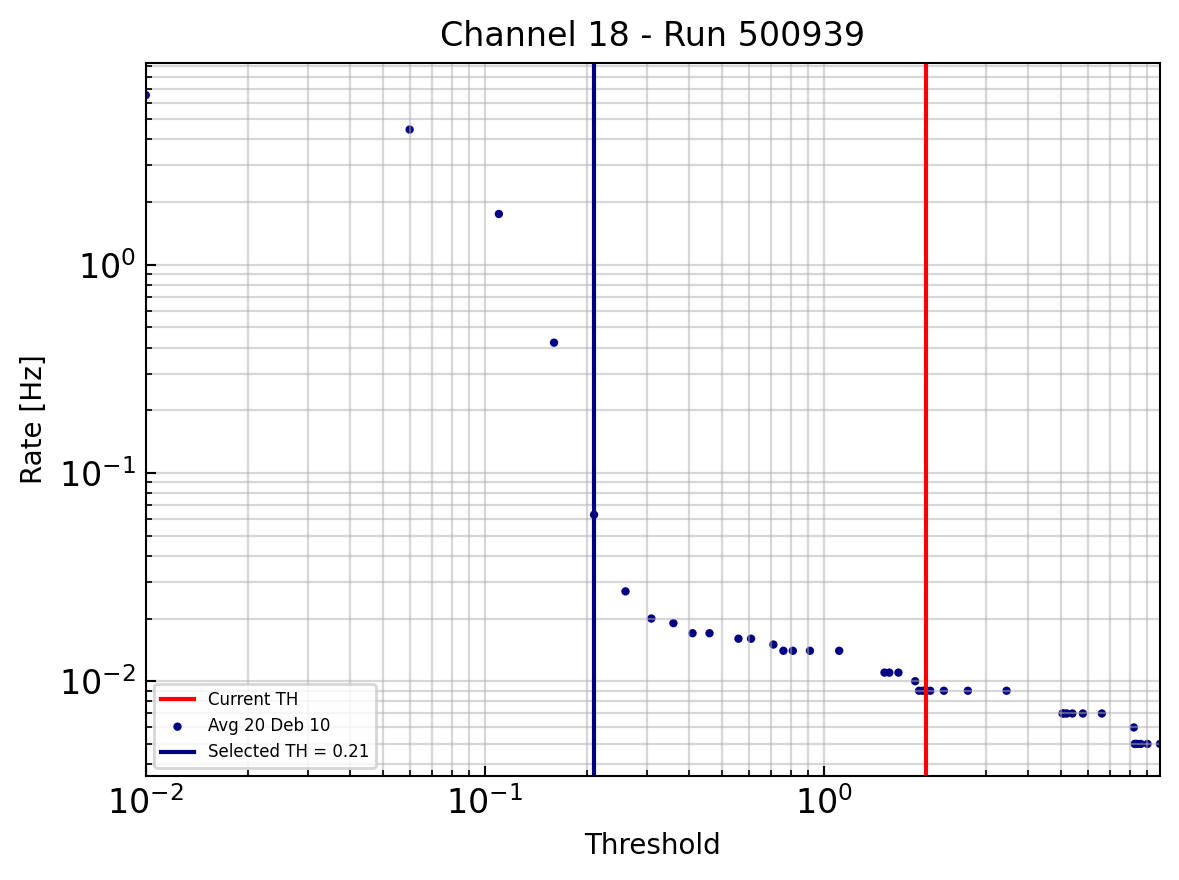

In [116]:
for it,run in enumerate(Runs):
  # Thresholdfile =  open(f'/data/users/berettam/DianaHallC/vibes/src/dev/TriggerParameters/AutoTrigParams_Run{run}.txt', 'w')
  for ch in AvailLDs:#]AvailHDs: #[20]:# [10]:#
    fig, ax = plt.subplots(1)  
    # figD, axD = plt.subplots(1)  
    #plot the current SB threshold
    currth = sb[run][sb[run].id==ch]['deriv. trg threshold'].values[0]            
    ax.axvline(currth,color = "r",label = 'Current TH')       
    # axD.axvline(currth,color = "r",label = 'Current TH') 
    
    for navg ,Avg in enumerate(Averages):
     for ndeb,Deb in enumerate(Debounce):
    
      selsp = np.logical_and.reduce((np.equal(AllScans.Run.to_numpy(),run), 
                                     np.equal(AllScans.Channel,ch) , 
                                     np.equal(AllScans.Debounce,Deb), 
                                     np.equal(AllScans.Average,Avg)))

      if np.sum(selsp)>0:

        ths = AllScans[selsp].THs.values[0]
        rates = AllScans[selsp].Rates.values[0]

        SelTH = ths[np.min(np.argwhere(np.less(rates,1/10)))]
        # Thresholdfile.write(f"{ch} {int(Avg)} {SelTH} {int(Deb)}\n")
        #plot
        # print(f"{Deb}) {int((ndeb+1))} / {np.size(Debounce)}")
        ax.scatter(ths,rates,
                   color = cmap(navg/np.size(Averages)),
                   marker=markers[int((ndeb))],linestyle='',
                              label=f"Avg {Avg} Deb {Deb}",s = 4)
          
        ax.axvline(SelTH,color = cmap(navg/np.size(Averages)),label = f'Selected TH = {SelTH:.2f}')
        # axD.axvline(SelTH,color = cmap(navg/np.size(Averages)),label = 'Selected TH') 

        _,sel = np.unique(rates,return_index=True)
        # axD.scatter(ths[sel][1:],np.diff(rates[sel]),
        #            color = cmap(navg/np.size(Averages)),
        #            marker=markers[int((ndeb+1)/np.size(Debounce))],linestyle='',
        #                       label=f"Avg {Avg} Deb {Deb}",s = 4)

        
        
        # ax.axvspan(currth, currth, facecolor='r', alpha=1,label = 'Current TH')
    ax.set( yscale='log',
            xscale='log',
            xlabel = 'Threshold',
            ylabel = 'Rate [Hz]',
            title = f'Channel {ch} - Run {run}', # + CHNameMap[ch],
            xlim = [np.min(ths),np.max(ths)])#np.max(freqs)])np.min(ths)
    # axD.set(yscale='log',xlabel = 'Diff Threshold',
    #         ylabel = 'Rate [Hz]',
    #         title = f'Channel {ch} - Run {run}', # + CHNameMap[ch],
    #         xlim = [np.min(ths),np.max(ths)])#np.max(freqs)])np.min(ths)
    ax.legend(loc='lower left',prop={'size': 6})
    # axD.legend(loc='lower left',prop={'size': 6})
  
    # ax.figure.savefig(OrPath+f'/Plots/Run{run}/Integral/IntegralThresholdScan_Run{run}_CH{ch}.png',dpi=600) 
    # axD.figure.savefig(OrPath+f'/Plots/Run{run}/Differential/DifferentialThresholdScan_Run{run}_CH{ch}.png',dpi=600)  
    # plt.close(fig)
    # plt.close(figD)
  # Thresholdfile.close()

Checkignt the db scan for CH 12

In [7]:
Averages=[2,6,10,20,40,60]
Debounces = [2,4,6,8,10]

MarkerDebounce = {}
MarkerDebounce[2] = 'o'
MarkerDebounce[4] = '+'
MarkerDebounce[6] = 'v'
MarkerDebounce[8] = 's'
MarkerDebounce[10] = '^'

ColAvgs = {}
ColAvgs[100] = 'tab:blue'
ColAvgs[80] = 'tab:orange'
ColAvgs[60] = 'tab:green'
ColAvgs[40] = 'tab:red'
ColAvgs[20] = 'tab:purple'
ColAvgs[10] = 'tab:gray'
ColAvgs[6] = 'tab:pink'
ColAvgs[2] = 'turquoise'

OrPathScan = 'H:/My Drive/2023_CCVRUSA_LSC/Analysis/ThresholdScan/TrigScan_MultiSpace/'

In [11]:
column_names = ["Run", "Channel", "THs","Rates","Average","Debounce"]

AllScans = pd.DataFrame(columns = column_names)
for ch in [12,14,16,18,20]:
  for av in Averages:
    for db in Debounces:
      f = OrPathScan+f'Avg{av:.0f}/Deb{db:.0f}/run950035/ScanTHs_run950035_CH{ch}.txt'

      #read the scan
      my_data = pd.read_csv(f)
      ths = my_data.Threshold.to_numpy()
      rate = my_data.Rate.to_numpy()
      
      #filling the df
      el = [950035,ch,ths,rate,av,db] 
      ss = pd.DataFrame([el],columns = column_names)
      AllScans = AllScans.append(ss);

In [12]:
plotsavg = {av: plt.subplots(1) for av in Averages}
plotsdb = {db: plt.subplots(1) for db in Debounces}
fig, ax = plt.subplots(1)  
cmap = plt.cm.get_cmap('jet')
ch = 14



for av in Averages:
  for db in Debounces:
  
    selsp = np.logical_and.reduce((np.equal(AllScans.Debounce.to_numpy(),db), 
                                   np.equal(AllScans.Average.to_numpy(),av), 
                                   np.equal(AllScans.Channel,ch)))

    if np.sum(selsp)>0:
      ths = AllScans[selsp].THs.values[0]
      rates = AllScans[selsp].Rates.values[0]
      #plot
      ax.errorbar(ths*av,rates,yerr=0,xerr=0,color = ColAvgs[av],
                            marker=MarkerDebounce[db], fmt = '',linestyle='',label=f"Avg {av} - Deb {db} ",ms = 4)
      plotsavg[av][0].axes[0].errorbar(ths*av,rates,yerr=0,xerr=0,color = ColAvgs[av],
                            marker=MarkerDebounce[db], fmt = '',linestyle='',label=f"Avg {av} - Deb {db} ",ms = 4)
      plotsdb[db][0].axes[0].errorbar(ths*av,rates,yerr=0,xerr=0,color = ColAvgs[av],
                            marker=MarkerDebounce[db], fmt = '',linestyle='',label=f"Avg {av} - Deb {db} ",ms = 4)
    
    
        
ax.set( yscale='log',
        xscale='log',
        xlabel = 'Threshold',
        ylabel = 'Rate [Hz]',
        title = f'Channel {ch} ' + CHNameMap[ch])
ax.legend(loc='best',prop={'size': 6})

for av in plotsavg:
  
  plotsavg[av][0].axes[0].set( yscale='log',
          xscale='log',
          xlabel = 'Threshold',
          ylabel = 'Rate [Hz]',
          title = f'Channel {ch} ' + CHNameMap[ch])
  plotsavg[av][0].axes[0].legend(loc='best',prop={'size': 6})
for db in plotsdb:
  
  plotsdb[db][0].axes[0].set( yscale='log',
          xscale='log',
          xlabel = 'Threshold',
          ylabel = 'Rate [Hz]',
          title = f'Channel {ch} ' + CHNameMap[ch])
  plotsdb[db][0].axes[0].legend(loc='best',prop={'size': 6})